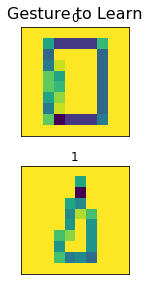

In [48]:
from sklearn import datasets
import numpy as np
from nxsdk_modules.epl.src.multi_pattern_learning.epl_multi_pattern_learning import EPLMultiPatternLearning
from nxsdk_modules.epl.src.multi_pattern_learning.epl_parameters import ParamemtersForEPL
import matplotlib.pyplot as plt

def getLabelAndImageData(labelFile, imageFile):
    try:
        labelData = np.load(labelFile)
        imageData = np.load(imageFile)
    except IOError:
        print("Cannot Open Label Files or Image Files")
        raise
    return labelData, imageData

#define utility functions
#create the training dataset by choosing the appropriate images of the digts to be learned
def get_training_data(digits, fourX=True, idx=0):
    train_data = []
    for digit in digits:
        training_image = image_dict[digit][idx]
        #print(training_image)
        #plt.imshow(training_image)
        #plt.show()
        training_image = np.ndarray.astype(training_image, int)
        if fourX: 
            training_image = (training_image//4)*4
        training_image = np.ndarray.flatten(training_image).tolist()
        #print(training_image)
        train_data.append(training_image)
    return train_data

# display the images of the patterns (digits) to be learned
def plot_images(digits, data, title):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4, 4),
                        subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axs.flat):
        img = data[i]
        img = np.reshape(img, (10,10))
        ax.imshow(img, interpolation=None, cmap='viridis')
        ax.set_title(str(digits[i]))
    plt.tight_layout()
    fig.suptitle(title, fontsize=16)
    plt.show()

trainLabelsFile="2GestureSet/labelTrain.npy"             
trainImagesFile="2GestureSet/imageTrain.npy"
inferLabelsFile="2GestureSet/labelInfer.npy"
inferImagesFile="2GestureSet/imageInfer.npy"
trainLabelData,trainImageData = getLabelAndImageData(trainLabelsFile, trainImagesFile)
inferLabelData,inferImageData = getLabelAndImageData(inferLabelsFile, inferImagesFile)

# load the digits dataset which consists of 8X8 images of digits
#digits = datasets.load_digits()
#images = digits.images
#targets = digits.target
images = trainImageData
targets = trainLabelData

# create a map of {digt->list of images of the digits}
#image_dict = {n : [] for n in range(10)}
image_dict = {n : [] for n in range(2)}
for t, img in zip(targets, images):
    image_dict[t].append(img)
    
    
numPatterns = 2
#choose 2 Gestures
gestures = [0, 1]

# generate the training data
train_data = get_training_data(digits=gestures)

# visulize the training data    
plot_images(gestures, train_data, title="Gesture to Learn")


createMCAndSTONetwork took 0.14997 secs
createMCToGCNetwork took 0.99011 secs
compileAndGetBoard took 1.67606 secs


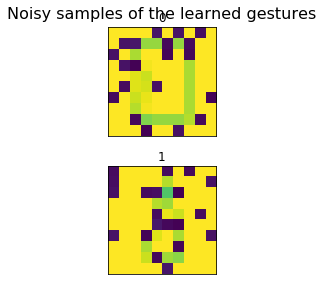

IndexError: list index out of range

In [49]:

# define the parameters
eplParams = ParamemtersForEPL()
eplParams.numPatterns = numPatterns
# Image size is 10X10 and we are using only 1MC per column,
eplParams.numColumns = 10
eplParams.numMCsPerColumn = 10
# Use 5 GCs per column per pattern, default is 5
eplParams.numGCsPerPatternPerColumn = 5
eplParams.connProbMCToGC = 0.2
eplParams.numDelaysMCToGC = 2
eplParams.useRandomSeed = True
eplParams.randomGenSeed = 100
eplParams.numGammaCyclesTrain = 45
# create the network
epl = EPLMultiPatternLearning(eplParams=eplParams)

# generate 5 noisy test samples for each pattern
numTestSamples = 5
occlusionPercent = 0.2 # randomly perturb only 20% of the image pixels
test_data = epl.generateTestingData(trainingData=train_data,
                                occlusionPercent=occlusionPercent,
                                numTestSamples=numTestSamples)

#visualize the test data by displaying the 3rd test sample for each pattern
test_data_subset = []
sampleIdx=3
for patternIdx in range(numPatterns):
    idx = patternIdx * numTestSamples + sampleIdx
    test_data_subset.append(test_data[idx])

#plot the 3rd test sample for each pattern
plot_images(gestures, test_data_subset, title="Noisy samples of the learned gestures")

epl.fit(trainingSet=train_data, testingSet=test_data)

epl.predict()

epl.evaluate(similarityThreshold=0.85)

epl.showRasterPlot(patternIdx=0, sampleIdx=3)

#Change the number of dendrites between MC->GC connections
eplParams.numDelaysMCToGC = 3 # was 2 before

#create a new network and redo the above process
epl = EPLMultiPatternLearning(eplParams=eplParams)

# This dumps a lot of output
epl.fit(trainingSet=train_data, testingSet=test_data)
epl.predict()

# Accuracy improves to 97% instead of 83% from before
epl.evaluate(similarityThreshold=0.85)